# Analyze modifications of the gamma rule on the entire VGG network

#### Loading stuff

In [18]:
%load_ext autoreload
%autoreload 2

device = "cpu"
PATH = './models/mnist_cnn.torch'
data_dir = "./dataset"
cat16_dir = data_dir + "/cat16"

import os
import torch
import copy
from tqdm import tqdm

from util.util_cnn import get_test_loader, CNN, test

from util.util_gamma_rule import global_conv_matrix, forw_surrogate_matrix,  \
                back_matrix, smart_gamma_func, \
                calc_evals, calc_evals_batch, \
                plot_evals_lineplot, \
                conv_matrix_from_pytorch_layer, \
                global_conv_matrix_from_pytorch_layer

from util.util_gamma_layers import GammaPerNeuronLayer, GammaWoSignFlipsLayer

from util.util_data_summary import *

import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# vgg experiments
import cv2
import torchvision
from torchvision import transforms, datasets
from PIL import Image

# lrp-tutorial sub repo
from lrp_tutorial import utils as tut_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load castle pic

(224, 224, 3)


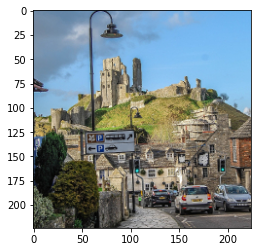

In [19]:
img = np.array(cv2.imread('lrp_tutorial/castle.jpg'))[...,::-1]/255.0
print(img.shape)
plt.imshow(img)

In [36]:
img.shape

(224, 224, 3)

In [37]:
img.mean(axis=(0,1))

array([0.45045549, 0.50725267, 0.52319287])

In [20]:
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

X = (torch.FloatTensor(img[None].transpose([0,3,1,2])*1) - mean) / std

X.shape

torch.Size([1, 3, 224, 224])

### Load pics of best cats in the world

In [4]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

cat16_files = np.sort([f for f in os.listdir(cat16_dir) if f.endswith('.jpeg')]) 
cat16_raw = [Image.open(os.path.join(cat16_dir, file)) for file in cat16_files]
cat16_cropped = [preprocess(img) for img in cat16_raw]
cat16 = norm(torch.stack(cat16_cropped))

if False: # plot cats
    fig, axs = plt.subplots(2, 8, figsize=(20,5))
    axs = axs.ravel()

    for i in range(16):
        axs[i].imshow(np.array(cat16_cropped[i]).transpose([1,2,0]))

    plt.show()

### Load VGG16 model

In [21]:
vgg = torchvision.models.vgg16(pretrained=True); vgg.eval()
layers = list(vgg._modules['features']) + tut_utils.toconv(list(vgg._modules['classifier']))
L = len(layers)

/Users/johannes/Applications/miniconda3/envs/msc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/johannes/Applications/miniconda3/envs/msc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0 Linear(in_features=25088, out_features=4096, bias=True)
3 Linear(in_features=4096, out_features=4096, bias=True)
6 Linear(in_features=4096, out_features=1000, bias=True)


In [22]:
list(vgg._modules['features'])

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [23]:
tut_utils.toconv(list(vgg._modules['classifier']))

0 Linear(in_features=25088, out_features=4096, bias=True)
3 Linear(in_features=4096, out_features=4096, bias=True)
6 Linear(in_features=4096, out_features=1000, bias=True)


[Conv2d(512, 4096, kernel_size=(7, 7), stride=(1, 1)),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Conv2d(4096, 4096, kernel_size=(1, 1), stride=(1, 1)),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Conv2d(4096, 1000, kernel_size=(1, 1), stride=(1, 1))]

In [24]:
A = [X]+[None]*L
# A = [cat16[:1]]+[None]*L
for l in range(L): A[l+1] = layers[l].forward(A[l])

In [25]:
scores = np.array(A[-1].data.view(-1))
ind = np.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(tut_utils.imgclasses[i][:20],i,scores[i]))

              castle (483): 11.029
church, church build (497):  9.522
           monastery (663):  9.401
 bell cote, bell cot (442):  9.047
cinema, movie theate (498):  8.016
        analog clock (409):  7.109
         street sign (919):  7.103
traffic light, traff (920):  7.058
thatch, thatched roo (853):  6.978
                 alp (970):  6.812


<p>We observe that the neuron castle (index 483) has the highest score. This is expected due to the presence of a castle in the image. Note that other building-related classes are also assigned a high score, as well as classes corresponding to other objects present in the image (e.g. street sign and traffic light).</p>

<h3>2.2 &nbsp; Explaining the prediction with LRP</h3>

<p>The following code iterates from the top layer to the first layer in reverse order and applies propagation rules at each layer. Top-layer activations are first multiplied by the mask to retain only the predicted evidence for the class "castle".</p>

In [26]:
T = torch.FloatTensor((1.0*(np.arange(1000)==483).reshape([1,1000,1,1])))

R = [None]*L + [(A[-1]*T).data]
#R = [None]*L + [(A[-1]).data]   # <-- unmasked !!!

<p>This evidence can then be propagated backward in the network by applying propagation rules at each layer.</p>

<p><b>Convolution layers:</b> Observing that convolutions are special types of linear layers, we can use the same propagation rules as in the MNIST example, and a similar four-step procedure for applying these rules. Steps 2 and 4 are simple element-wise computations. Step 1 can be implemented as a forward computation in the layer, where we have preliminary transformed the layer parameters, and where we apply the increment function afterwards. As shown in the LRP overview paper, Step 3 can instead be computed as a gradient in the space of input activations:</p>

<img src="http://latex.codecogs.com/svg.latex?c_j = \big[\nabla~\big({\textstyle \sum_k}~z_k(\boldsymbol{a}) \cdot s_k\big)\big]_j">

<p>where <i>s<sub>k</sub></i> is treated as constant.</p>

<p><b>Pooling layers:</b> It is suggested in Section 10.3.2 of the paper to treat max-pooling layers as average pooling layers in the backward pass. Observing that average pooling is also a special linear layer, the same propagation rules as for the convolutional layers become applicable.</p>

<p>In the following code, we iterate the propagation procedure from the top-layer towards the lower layers. Whenever we meet a max-pooling layer, we convert it into an average pooling layer. The function <code>rho</code> and <code>incr</code> are set differently at each layer, following the strategy of Section 10.3.</p>

In [35]:
for i in range(L):
    print(i, A[i].shape)

0 torch.Size([1, 3, 224, 224])
1 torch.Size([1, 64, 224, 224])
2 torch.Size([1, 64, 224, 224])
3 torch.Size([1, 64, 224, 224])
4 torch.Size([1, 64, 224, 224])
5 torch.Size([1, 64, 112, 112])
6 torch.Size([1, 128, 112, 112])
7 torch.Size([1, 128, 112, 112])
8 torch.Size([1, 128, 112, 112])
9 torch.Size([1, 128, 112, 112])
10 torch.Size([1, 128, 56, 56])
11 torch.Size([1, 256, 56, 56])
12 torch.Size([1, 256, 56, 56])
13 torch.Size([1, 256, 56, 56])
14 torch.Size([1, 256, 56, 56])
15 torch.Size([1, 256, 56, 56])
16 torch.Size([1, 256, 56, 56])
17 torch.Size([1, 256, 28, 28])
18 torch.Size([1, 512, 28, 28])
19 torch.Size([1, 512, 28, 28])
20 torch.Size([1, 512, 28, 28])
21 torch.Size([1, 512, 28, 28])
22 torch.Size([1, 512, 28, 28])
23 torch.Size([1, 512, 28, 28])
24 torch.Size([1, 512, 14, 14])
25 torch.Size([1, 512, 14, 14])
26 torch.Size([1, 512, 14, 14])
27 torch.Size([1, 512, 14, 14])
28 torch.Size([1, 512, 14, 14])
29 torch.Size([1, 512, 14, 14])
30 torch.Size([1, 512, 14, 14])
31 to

In [30]:
conv_layer  = copy.deepcopy(layers[5])

gamma_per_neuron_layer = GammaPerNeuronLayer(conv_layer, gamma_scale=0.95)
gamma_per_neuron_layer = GammaWoSignFlipsLayer(conv_layer, gamma=0.5)
gamma_per_neuron_layer.forward(A[5]);

fraction sign flips: tensor(0.5068)


In [31]:
modes = {
    0: "LRP-0", 
    5: "LRP-composite", 

    # 11: "Gamma per Neuron >= 20", 
    # 12: "Gamma per Neuron < 20", 
    
    # 21: "Gamma wo Sign Flips >= 20", 
    # 22: "Gamma wo Sign Flips < 16",

    # 99: "info"
}
relevancies_per_mode = {}

def rel(index):
    if type(index) is int:
        index = modes[index]
    assert type(index) is str
    return copy.deepcopy(relevancies_per_mode[index])

In [32]:
for mode in tqdm(modes.values()):
    if mode in relevancies_per_mode: continue

    for l in range(1,L)[::-1]:
        
        A[l] = (A[l].data).requires_grad_(True)

        if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

        if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

            if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
            if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            if l >= 31 or mode=="LRP-0":       
                              rho = lambda p: p;                       incr = lambda z: z+1e-9

            if not isinstance(layers[l],torch.nn.Conv2d):
                helper_layer = tut_utils.newlayer(layers[l], rho)

            elif mode=='Gamma per Neuron < 20' and l < 20:
                helper_layer = GammaPerNeuronLayer(layers[l], gamma_scale=0.999, diffusion=0.0)
            elif mode=='Gamma per Neuron >= 20' and l >= 20:
                helper_layer = GammaPerNeuronLayer(layers[l], gamma_scale=0.999, diffusion=0.0)
            elif mode=='Gamma wo Sign Flips < 16' and l < 16:
                helper_layer = GammaWoSignFlipsLayer(layers[l], gamma=0.5)
            elif mode=='Gamma wo Sign Flips >= 20' and l >= 20:
                helper_layer = GammaWoSignFlipsLayer(layers[l], gamma=0.5)

            else: # fallback to LRP composite for all other layers
                helper_layer = tut_utils.newlayer(layers[l], rho)

            z = incr(helper_layer.forward(A[l]))                            # step 1
            s = (R[l+1]/z).data                                             # step 2
            (z*s).sum().backward(); c = A[l].grad                           # step 3
            R[l] = (A[l]*c).data                                            # step 4

            if mode=='info':
                print(A[l].shape, '->', z.shape)
                print(A[l].flatten().shape, '->', z.flatten().shape)
            
        else:
            R[l] = R[l+1]

    if mode=="info": continue
    relevancies_per_mode[mode] = copy.deepcopy(R)

100%|██████████| 1/1 [00:06<00:00,  6.41s/it]


In [ ]:
for i in range(L):
    print(i, R[i].shape if R[i] is not None else "")

As each layer is composed of a collection of two-dimensional feature maps, relevance scores at each layer can be visualized as a two-dimensional map. Here, relevance scores are pooled over all feature maps at a given layer. The two-dimensional maps are shown for a selection of VGG-16 layers.

In [ ]:
for i,l in enumerate([31,21,11,1]):
    tut_utils.heatmap(np.array(R[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)

mean absolute relevancy tensor(0.3117)


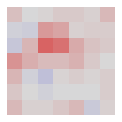

mean absolute relevancy tensor(0.0720)


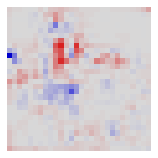

mean absolute relevancy tensor(0.0114)


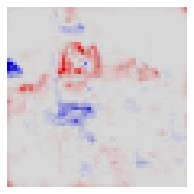

mean absolute relevancy tensor(0.0043)


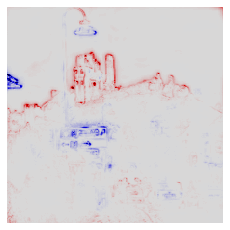

In [51]:
R = rel(11)

for i,l in enumerate([31,21,11,1]):
    print("mean absolute relevancy", np.abs(R[l][0]).max())
    tut_utils.heatmap(np.array(R[l][0]).sum(axis=0), 0.5*i+1.5,0.5*i+1.5)

mean absolute relevancy tensor(0.3117)


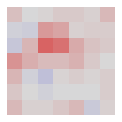

mean absolute relevancy tensor(0.0254)


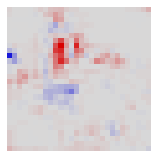

mean absolute relevancy tensor(0.0037)


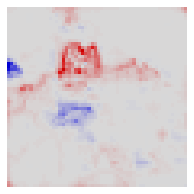

mean absolute relevancy tensor(0.0018)


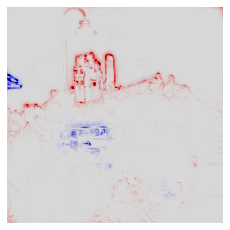

In [48]:
R = rel(0)

for i,l in enumerate([31,21,11,1]):
    print("mean absolute relevancy", np.abs(R[l][0]).max())
    tut_utils.heatmap(np.array(R[l][0]).sum(axis=0), 0.5*i+1.5,0.5*i+1.5)

max absolute difference tensor(0.)


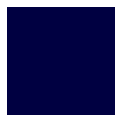

max absolute difference tensor(0.0322)


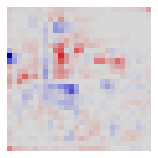

max absolute difference tensor(0.0083)


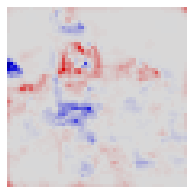

max absolute difference tensor(0.0025)


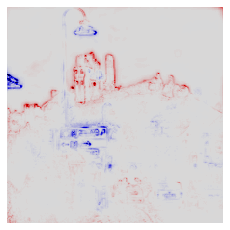

In [50]:
R = [R1 - R2 for R1, R2 in zip(rel(11), rel(0)) if R1 is not None and R2 is not None]

for i,l in enumerate([31,21,11,1]):
    print("max absolute difference", np.abs(R[l][0]).max())
    tut_utils.heatmap(np.array(R[l][0]).sum(axis=0), 0.5*i+1.5,0.5*i+1.5)

<p>We observe that the explanation becomes increasingly resolved spatially. Note that, like for the MNIST example, we have stopped the propagation procedure one layer before the pixels because the rule we have used is not applicable to pixel layers. Like for the MNIST case, we need ot apply the pixel-specific zB-rule for this last layer. This rule can again be implemented in terms of forward passes and gradient computations.</p>

In [141]:
A[0] = (A[0].data).requires_grad_(True)

lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
z -= tut_utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
z -= tut_utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
s = (R[1]/z).data                                                      # step 2
(z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4

The relevance scores obtained in the pixel layer can now be summed over the RGB channels to indicate actual pixel-wise contributions.

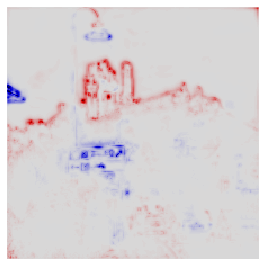

In [142]:
tut_utils.heatmap(np.array(R[0][0]).sum(axis=0),3.5,3.5)

In [143]:
print("NOTE: we only look at one convolutional filter (of 64) of the first layer, and we only look at ONE COLOR CHANNEL (of three that the conv filter is using)!")
print(layers[0].weight.detach().numpy().shape)
print(layers[0].weight.detach().numpy()[0,0].shape)

NOTE: we only look at one convolutional filter (of 64) of the first layer, and we only look at ONE COLOR CHANNEL (of three that the conv filter is using)!
(64, 3, 3, 3)
(3, 3)


In [15]:
layers_no = 0
filter_no = 0
color_no = 0

color_channel_one = X[0, color_no].detach() # from the batch, take only the first image, take only the first color channel.
trans = conv_matrix_from_pytorch_layer(layers[layers_no], X[0].shape, filter_no, color_no)
trans.shape

(50176, 50176)